## Network from Kell, Yamins, Shook, Norman-Haignere, McDermott, 2018

This notebook shows how to create a tensorflow graph for the network with the weights and biases used in <a href="https://www.cell.com/neuron/fulltext/S0896-6273(18)30250-2">Kell et al., 2018</a>. This notebook also gives an example of how to pass a sound into the network.


### Note on network input

The input to the network is a "cochleagram", a time-frequency decomposition of a sound that is similar to a spectrogram. Below we provide examples of how to pass a pre-computed cochleagram into the network, as well as how to compute the cochleagram for an example wav and then pass that cochleagram to the network.

### Dependencies

Most of the dependencies to run this are relatively standard. However, please note the following:
- This notebook was tested and run with version 1.5.0 of `tensorflow`. It was not tested with other versions.
- `pycochleagram` is a module to generate cochleagrams to pass sounds into the network, which can be found <a href="https://github.com/mcdermottLab/pycochleagram">here</a>.
- `PIL` is the Python Image Library.

### Contact
If you have any questions, please contact Alex Kell. Email: < first_name >< last_name >@mit.edu.

Thanks, and enjoy!

In [1]:
import IPython.display as ipd
import sys
sys.path.append('./network/')
from branched_network_class import branched_network
import tensorflow as tf
import scipy.io.wavfile as wav
import matplotlib as plt 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/davidlee/dev/kelletal2018/venv/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# import the following to run demo_from_wav()
from pycochleagram import cochleagram as cgram 
from PIL import Image

In [3]:
## Some helper functions
def resample(example, new_size):
    im = Image.fromarray(example)
    resized_image = im.resize(new_size, resample=Image.ANTIALIAS)
    return np.array(resized_image)

def plot_cochleagram(cochleagram, title): 
    plt.figure(figsize=(6,3))
    plt.matshow(cochleagram.reshape(256,256), origin='lower',cmap=plt.cm.Blues, fignum=False, aspect='auto')
    plt.yticks([]); plt.xticks([]); plt.title(title); 
    
def play_wav(wav_f, sr, title):   
    print title+':'
    ipd.display(ipd.Audio(wav_f, rate=sr))

In [4]:
def demo_pre_generated_cochleagram():
    tf.reset_default_graph()

    net_object = branched_network() # make network object
    word_key = np.load('./demo_stim/logits_to_word_key.npy') #Load logits to word key 
    music_key = np.load('./demo_stim/logits_to_genre_key.npy') #Load logits to genre key

    # example pre-generated speech cochleagram 
    example_cochleagram = np.load('./demo_stim/example_cochleagram_0.npy') 
    plot_cochleagram(example_cochleagram,'Example speech cochleagram' )

    # run cochleagram through network and get logits for word branch
    logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: example_cochleagram})

    # determine word branch prediction 
    prediction = word_key[np.argmax(logits, axis=1)]
    print "Speech Example ... actual label: according  predicted_label: " + prediction[0] +'\n'
    
    # example pre-generated music cochleagram
    example_cochleagram_music = np.load('./demo_stim/example_cochleagram_1.npy') 
    plot_cochleagram(example_cochleagram_music,'Example music cochleagram' )
    
    # run cochleagram through network and get logits for genre branch
    logits_music = net_object.session.run(net_object.genre_logits, 
                                          feed_dict={net_object.x: example_cochleagram_music})
    # note: throughout paper top-5 accuracy is reported for genre task
    prediction_music = (logits_music).argsort()[:,-5:][0][::-1] 
    print "Music Example... actual label: "+ music_key[11]+ "  top-5 predicted_labels (in order of confidence): "
    print "\n"+ "; ".join(music_key[prediction_music])

    

In [5]:
def generate_cochleagram(wav_f, sr, title):
    # define parameters
    n, sampling_rate = 50, 16000
    low_lim, hi_lim = 20, 8000
    sample_factor, pad_factor, downsample = 4, 2, 200
    nonlinearity, fft_mode, ret_mode = 'power', 'auto', 'envs'
    strict = True

    # create cochleagram
    c_gram = cgram.cochleagram(wav_f, sr, n, low_lim, hi_lim, 
                               sample_factor, pad_factor, downsample,
                               nonlinearity, fft_mode, ret_mode, strict)
    
    # rescale to [0,255]
    c_gram_rescaled =  255*(1-((np.max(c_gram)-c_gram)/np.ptp(c_gram)))
    
    # reshape to (256,256)
    c_gram_reshape_1 = np.reshape(c_gram_rescaled, (211,400))
    c_gram_reshape_2 = resample(c_gram_reshape_1,(256,256))
    
    plot_cochleagram(c_gram_reshape_2, title)

    # prepare to run through network -- i.e., flatten it
    c_gram_flatten = np.reshape(c_gram_reshape_2, (1, 256*256)) 
    
    return c_gram_flatten

In [6]:
def demo_from_wav():
    tf.reset_default_graph()
    net_object = branched_network()
    word_key = np.load('./demo_stim/logits_to_word_key.npy') # load logits to word key
    music_key = np.load('./demo_stim/logits_to_genre_key.npy') # load logits to word key 
    
    
    # generate cochleagram, then pass cochleagram through network and get logits for word branch
    
    ## Speech examples
    
    # example 1:
    sr, wav_f = wav.read('./demo_stim/example_1.wav') # note the sampling rate is 16000hz.
    play_wav(wav_f, sr, 'Example 1')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 1')
    logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
    prediction = word_key[np.argmax(logits, axis=1)]
    print "Speech Example ... \n clean speech, actual label: Increasingly, predicted_label: " \
        + prediction[0] +'\n'
    
    # example 2:
    sr, wav_f = wav.read('./demo_stim/example_2.wav') 
    play_wav(wav_f, sr, 'Example 2')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 2')
    logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
    prediction = word_key[np.argmax(logits, axis=1)]
    print "Speech Example ... \n background: speaker shaped noise, snr: -3db, actual label: Washington, predicted_label: " \
        + prediction[0] +'\n'
    
    # example 3:
    sr, wav_f = wav.read('./demo_stim/example_3.wav') 
    play_wav(wav_f, sr, 'Example 3')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 3')
    logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
    prediction = word_key[np.argmax(logits, axis=1)]
    print "Speech Example ... \n background: music, snr: 3db, actual label: Movies, predicted_label: " \
        + prediction[0] +'\n'
    
     
    # example 4:
    sr, wav_f = wav.read('./demo_stim/example_4.wav') 
    play_wav(wav_f, sr, 'Example 4')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 4')
    logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
    prediction = word_key[np.argmax(logits, axis=1)]
    print "Speech Example ... \n background: 2-spkr babble, snr: -6db, actual label: Equipment  predicted_label: " \
        + prediction[0] +'\n'
    
    # example 5:
    sr, wav_f = wav.read('./demo_stim/example_5.wav') 
    play_wav(wav_f, sr, 'Example 5')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 5')
    logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
    prediction = word_key[np.argmax(logits, axis=1)]
    print "Speech Example ... \n background: Auditory scene, snr: -9db, actual label: Advantage  predicted_label: " \
        + prediction[0] +'\n'
    
    
    
    
    ## Music examples 
    
    # example 6:
    sr, wav_f = wav.read('./demo_stim/example_6.wav') 
    play_wav(wav_f, sr, 'Example 6')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 6')
    logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
    prediction = (logits).argsort()[:,-5:][0][::-1] 
    print "Music Example ... \n Background: Auditory Scene, snr: -3db, actual label: " \
        + music_key[1] + ",\n top-5 predicted_labels (in order of confidence): \n " \
        + ";\n ".join(music_key[prediction]) + "\n"
    
    # example 7:
    sr, wav_f = wav.read('./demo_stim/example_7.wav') 
    play_wav(wav_f, sr, 'Example 7')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 7')
    logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
    prediction = (logits).argsort()[:,-5:][0][::-1] 
    print "Music Example ... \n Background: Music-shaped noise, snr: -6db, actual label: " \
        + music_key[10] + ",\n top-5 predicted_labels (in order of confidence): \n " \
        + ";\n ".join(music_key[prediction]) + "\n"
    
    # example 8:
    sr, wav_f = wav.read('./demo_stim/example_8.wav') 
    play_wav(wav_f, sr, 'Example 8')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 8')
    logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
    prediction = (logits).argsort()[:,-5:][0][::-1] 
    print "Music Example ... \n Background: 8-spkr babble, snr: 3db, actual label: " \
        + music_key[33] + ",\n top-5 predicted_labels (in order of confidence): \n " \
        + ";\n ".join(music_key[prediction]) + "\n"
    
    # example 9:
    sr, wav_f = wav.read('./demo_stim/example_9.wav') # note the sampling rate is 16000hz.
    play_wav(wav_f, sr, 'Example 9')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 9')
    logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
    prediction = (logits).argsort()[:,-5:][0][::-1] 
    print "Music Example ... \n Background: 2-spkr babble, snr: 0db, actual label: " \
        + music_key[39] + ",\n top-5 predicted_labels (in order of confidence): \n " \
        + ";\n ".join(music_key[prediction]) + "\n"
    
    # example 10:
    sr, wav_f = wav.read('./demo_stim/example_10.wav') # note the sampling rate is 16000hz.
    play_wav(wav_f, sr, 'Example 10')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 10')
    logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
    prediction = (logits).argsort()[:,-5:][0][::-1] 
    print "Music Example ... \n Background: clean, actual label: " \
        + music_key[16] + ",\n top-5 predicted_labels (in order of confidence): \n " \
        + ";\n ".join(music_key[prediction]) + "\n"
    

In [7]:
def demo_from_wav():
    tf.reset_default_graph()
    net_object = branched_network()
    word_key = np.load('./demo_stim/logits_to_word_key.npy') # load logits to word key
    music_key = np.load('./demo_stim/logits_to_genre_key.npy') # load logits to word key 
    
    
    # generate cochleagram, then pass cochleagram through network and get logits for word branch
    
    ## Speech examples
    
    # example 1:
    sr, wav_f = wav.read('./demo_stim/example_1.wav') # note the sampling rate is 16000hz.
    play_wav(wav_f, sr, 'Example 1')
    c_gram = generate_cochleagram(wav_f, sr, 'Example 1')
    logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
    prediction = word_key[np.argmax(logits, axis=1)]
    print "Speech Example ... \n clean speech, actual label: Increasingly, predicted_label: " \
        + prediction[0] +'\n'
    
#     # example 2:
#     sr, wav_f = wav.read('./demo_stim/example_2.wav') 
#     play_wav(wav_f, sr, 'Example 2')
#     c_gram = generate_cochleagram(wav_f, sr, 'Example 2')
#     logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
#     prediction = word_key[np.argmax(logits, axis=1)]
#     print "Speech Example ... \n background: speaker shaped noise, snr: -3db, actual label: Washington, predicted_label: " \
#         + prediction[0] +'\n'
    
#     # example 3:
#     sr, wav_f = wav.read('./demo_stim/example_3.wav') 
#     play_wav(wav_f, sr, 'Example 3')
#     c_gram = generate_cochleagram(wav_f, sr, 'Example 3')
#     logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
#     prediction = word_key[np.argmax(logits, axis=1)]
#     print "Speech Example ... \n background: music, snr: 3db, actual label: Movies, predicted_label: " \
#         + prediction[0] +'\n'
    
     
#     # example 4:
#     sr, wav_f = wav.read('./demo_stim/example_4.wav') 
#     play_wav(wav_f, sr, 'Example 4')
#     c_gram = generate_cochleagram(wav_f, sr, 'Example 4')
#     logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
#     prediction = word_key[np.argmax(logits, axis=1)]
#     print "Speech Example ... \n background: 2-spkr babble, snr: -6db, actual label: Equipment  predicted_label: " \
#         + prediction[0] +'\n'
    
#     # example 5:
#     sr, wav_f = wav.read('./demo_stim/example_5.wav') 
#     play_wav(wav_f, sr, 'Example 5')
#     c_gram = generate_cochleagram(wav_f, sr, 'Example 5')
#     logits = net_object.session.run(net_object.word_logits, feed_dict={net_object.x: c_gram})
#     prediction = word_key[np.argmax(logits, axis=1)]
#     print "Speech Example ... \n background: Auditory scene, snr: -9db, actual label: Advantage  predicted_label: " \
#         + prediction[0] +'\n'
    
    
    
    
#     ## Music examples 
    
#     # example 6:
#     sr, wav_f = wav.read('./demo_stim/example_6.wav') 
#     play_wav(wav_f, sr, 'Example 6')
#     c_gram = generate_cochleagram(wav_f, sr, 'Example 6')
#     logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
#     prediction = (logits).argsort()[:,-5:][0][::-1] 
#     print "Music Example ... \n Background: Auditory Scene, snr: -3db, actual label: " \
#         + music_key[1] + ",\n top-5 predicted_labels (in order of confidence): \n " \
#         + ";\n ".join(music_key[prediction]) + "\n"
    
#     # example 7:
#     sr, wav_f = wav.read('./demo_stim/example_7.wav') 
#     play_wav(wav_f, sr, 'Example 7')
#     c_gram = generate_cochleagram(wav_f, sr, 'Example 7')
#     logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
#     prediction = (logits).argsort()[:,-5:][0][::-1] 
#     print "Music Example ... \n Background: Music-shaped noise, snr: -6db, actual label: " \
#         + music_key[10] + ",\n top-5 predicted_labels (in order of confidence): \n " \
#         + ";\n ".join(music_key[prediction]) + "\n"
    
#     # example 8:
#     sr, wav_f = wav.read('./demo_stim/example_8.wav') 
#     play_wav(wav_f, sr, 'Example 8')
#     c_gram = generate_cochleagram(wav_f, sr, 'Example 8')
#     logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
#     prediction = (logits).argsort()[:,-5:][0][::-1] 
#     print "Music Example ... \n Background: 8-spkr babble, snr: 3db, actual label: " \
#         + music_key[33] + ",\n top-5 predicted_labels (in order of confidence): \n " \
#         + ";\n ".join(music_key[prediction]) + "\n"
    
#     # example 9:
#     sr, wav_f = wav.read('./demo_stim/example_9.wav') # note the sampling rate is 16000hz.
#     play_wav(wav_f, sr, 'Example 9')
#     c_gram = generate_cochleagram(wav_f, sr, 'Example 9')
#     logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
#     prediction = (logits).argsort()[:,-5:][0][::-1] 
#     print "Music Example ... \n Background: 2-spkr babble, snr: 0db, actual label: " \
#         + music_key[39] + ",\n top-5 predicted_labels (in order of confidence): \n " \
#         + ";\n ".join(music_key[prediction]) + "\n"
    
#     # example 10:
#     sr, wav_f = wav.read('./demo_stim/example_10.wav') # note the sampling rate is 16000hz.
#     play_wav(wav_f, sr, 'Example 10')
#     c_gram = generate_cochleagram(wav_f, sr, 'Example 10')
#     logits = net_object.session.run(net_object.genre_logits, feed_dict={net_object.x: c_gram})
#     prediction = (logits).argsort()[:,-5:][0][::-1] 
#     print "Music Example ... \n Background: clean, actual label: " \
#         + music_key[16] + ",\n top-5 predicted_labels (in order of confidence): \n " \
#         + ";\n ".join(music_key[prediction]) + "\n"
    

## Demos

In [ ]:
demo_from_wav()

Speech Example ... actual label: according  predicted_label: according

Music Example... actual label: blues rock, hard rock  top-5 predicted_labels (in order of confidence): 

blues rock, hard rock; folk rock; 80s; punk, punk rock; disco


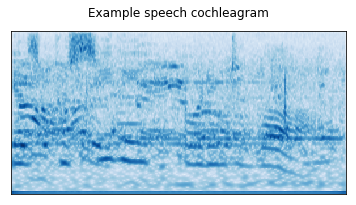

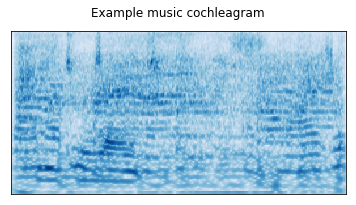

In [8]:
demo_pre_generated_cochleagram()